# Real estate ROI calculator 

## Configurables
Change your url and location here

In [1]:
import datetime

#Replace this url with the url of your search results
#url = 'https://www.immobilienscout24.de/Suche/de/berlin/berlin/wohnung-kaufen?enteredFrom=one_step_search'
# state/city
# location = "berlin/berlin" 
location = "baden-wuerttemberg/pforzheim"
# location = "niedersachsen/lueneburg-kreis"
# location = "bayern/fuerth-kreis"
# location = "baden-wuerttemberg/mannheim/"

# location = "sachsen-anhalt/magdeburg"
propertyType = 'wohnung'
# url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/rheinland-pfalz/alzey-worms-kreis/wohnung-kaufen?enteredFrom=result_list'

url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/' + location + '/'+propertyType+'-kaufen?enteredFrom=result_list'

actualDate = datetime.date.today()
actualDate = actualDate.strftime('%Y-%m-%d')
city = location.split('/')[1]
file_name_csv_raw = 'immobilienscout_result_' + city + '_' + actualDate + '.csv'
file_folder = 'data'
file_path = file_folder + '/' +  file_name_csv_raw

# Your variables to change
rent_price_index = 9
equity_percentage = 0.20
interest_rate = 0.01
mortgage_payment_rate = 0.02

# Standard percentages
notary_percentage = 0.015
transfer_tax_percentage = 0.05
land_registry_tax_percentage = 0.005
additional_costs_rate_per_m2 = 0.9 

## Setup

In [2]:
import urllib.request
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy import Selector
import selenium
from selenium import webdriver
import chromedriver_binary
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

import json
import re
import numpy as np
from crochet import setup

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:

columns = ['id_expose', 'url', 'title', 'address', 'contact_person', 'telephone', 'mobile', 'fax', 'price_purchase', 'estimated_monthly_rate', 'rooms', 'living_area_m2', 'furnishing', 'flat_type', 'floor', 'floor_total', 'bedrooms', 'commission_buyer_rate', 'maintenance_cost', 'construction_year', 'object_state', 'heating_type', 'energy_efficiency_class', 'location']
df_base = pd.DataFrame(columns = columns)

options = Options()
options.headless = True

crawler_name = 'scrapper_immobilienscout'

base_uri = 'immobilienscout24.de'
base_url = 'https://www.immobilienscout24.de'

In [4]:
driver = webdriver.Chrome()
# OLD configuration
#driver = webdriver.Chrome(options=options, executable_path="chromedriver.exe")

class Scrap_immobilienscout(scrapy.Spider):
    
    name = crawler_name
    
    def start_requests(self):
        first_page = urllib.request.urlopen(url_to_crawl)
        max_pages = first_page.read()
        max_pages = max_pages.decode("utf8")
        first_page.close()

        max_pages_selector = Selector(text = max_pages)
        max_pages = max_pages_selector.xpath('//select[@aria-label="Seitenauswahl"]/option[last()]/@value').extract_first()
        max_pages = int(max_pages) if max_pages is not None else 1
        
        base_url = url_to_crawl.replace('enteredFrom=one_step_search', '')


        print("********************MAX PAGES: ",max_pages)
        
        for page_number in range(max_pages):
            url = base_url + '&pagenumber=' + str(page_number + 1)
            print("********************URL: ",url)
            yield scrapy.Request(url, callback = self.parse_properties_list)
    
    def parse_properties_list(self, response):
        
        property_urls = response.xpath('//a[contains(@class, "result-list-entry__brand-title-container")]/@href').extract()
        
        for url in property_urls:
            if base_uri not in url:
                url = base_url + url + '#/'
                driver.get(url)
                src = driver.page_source
                self.scrap_property(src, url)
    
    # TODO rename variables
    # TODO clarify default values
    # TODO fix parse issues (int, roundings, etc.)
    def scrap_property(self, src, url):
        sel = Selector(text = src)

        id_expose = '' # TODO get expose substring of url
        
        title = sel.css('h1#expose-title ::text').extract_first()
        
        address = sel.xpath('//div[@class="address-block"]//span[@class="block font-nowrap print-hide"]//text()').extract_first()
        address = address.strip() if address is not None else ''

        region = sel.css('span.zip-region-and-country::text').extract_first()
        address += ' ' + region if region is not None else ''
        
        contact_person = sel.xpath('//div[@data-qa="contactName"]//text()').extract_first()
        contact_person = contact_person if contact_person is not None else ''
        
        phone = sel.xpath('//script//text()').extract_first()
        phone = phone if phone is not None else ''

        telefon = re.findall('"phoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        telefon = telefon[0].replace(' ', '') if len(telefon) > 0 else None
        
        mobil = re.findall('"cellPhoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        mobil = mobil[0] if len(mobil) > 0 else ''
        mobil = mobil.replace(' ', '')

        fax = re.findall('"faxNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        fax = fax[0] if len(fax) > 0 else ''
        fax = fax.replace(' ', '')
        
        price = sel.xpath('//dd[contains(@class, "is24qa-kaufpreis")]//text()').extract_first()
        price = re.sub('[^0-9]', '', price) if price is not None else 0
        price = int(price)
        
        estimated_monthly_rate = sel.xpath('//span[contains(@class, "monthly-rate-result") and contains(@class, "monthly-rate-value")]//text()').extract_first()
        estimated_monthly_rate = re.sub('[^0-9]', '', estimated_monthly_rate) if estimated_monthly_rate is not None else 0
        estimated_monthly_rate = int(estimated_monthly_rate)
        
        rooms_count = sel.xpath('//dd[contains(@class,"is24qa-zimmer")]/text()').extract_first()
        rooms_count = float(rooms_count.replace(" ","").replace(",",".") ) if rooms_count is not None else 0
        
        living_area = sel.xpath('//dd[contains(@class, "is24qa-wohnflaeche-ca")]/text()').extract_first()
        living_area = re.sub('[^0-9\.]', '', living_area.replace(",",".")) if living_area is not None else 0
        living_area = float(living_area)
        
        furnishing = sel.xpath('//div[contains(@class, "criteriagroup") and contains(@class, "boolean-listing")]//span[contains(@class, "palm-hide")]/text()').extract()
        furnishing = list(set(furnishing))
        furnishing = [t for t in furnishing if t != ' ']
        furnishing = furnishing if len(furnishing) > 0 else ''
        
        flat_type = sel.xpath('//dd[contains(@class, "is24qa-typ")]/text()').extract_first()
        
        floor = sel.xpath('//dd[contains(@class, "is24qa-etage")]//text()').extract_first()
        floor = floor if floor is not None else ''
        floor = re.findall('[0-9]+', floor)
        total_floors = int(floor[1]) if len(floor) > 1 else 0
        floor = int(floor[0]) if len(floor) > 0 else 0
        
        bedroom = sel.xpath('//dd[contains(@class, "is24qa-schlafzimmer")]//text()').extract_first()
        bedroom = re.sub('[^0-9]', '', bedroom) if bedroom is not None else 0
        bedroom = int(bedroom)
        
        allowance = sel.xpath('//dd[contains(@class, "is24qa-hausgeld")]//text()').extract_first()
        allowance = re.sub('[^0-9]', '', allowance) if allowance is not None else 0
        allowance = int(allowance)
        
        commission = sel.xpath('//dd[contains(@class, "is24qa-provision")]/text()').extract_first()
        
        if commission is not None:
            try:
                commission = re.search('[0-9]+,?[0-9]*', commission).group() 
            except:
                commission = ''
        else:
            commission = ''

        commission = commission.replace(',', '.')
        commission = float(commission) if len(commission) > 0 else 0
        
        construction_year = sel.xpath('//dd[contains(@class, "is24qa-baujahr")]//text()').extract_first()
        
        object_state = sel.xpath('//dd[contains(@class, "is24qa-objektzustand")]//text()').extract_first()
        
        heatingy_type = sel.xpath('//dd[contains(@class, "is24qa-heizungsart")]//text()').extract_first()
        
        energy_efficiency_class = sel.xpath('//dd[contains(@class, "is24qa-energieeffizienzklasse")]//text()').extract_first()
        energy_efficiency_class = energy_efficiency_class if energy_efficiency_class is not None else ''
        
        location = sel.xpath('//pre[contains(@class, "is24qa-lage")]/text()').extract_first()

        lst_row = [id_expose, url, title, address, contact_person, telefon, mobil, fax, price, estimated_monthly_rate, rooms_count, living_area, furnishing, flat_type, floor, total_floors, bedroom, commission, allowance, construction_year, object_state, heatingy_type, energy_efficiency_class, location]
        df_base.loc[len(df_base)] = lst_row
        df_base.to_csv(file_path, index=False)
        
# process = CrawlerProcess()
# process.crawl(Scrap_immobilienscout)
# process.start(),
setup()
def spider_process(spider):
    process = CrawlerProcess()
    process.crawl(spider)
    
spider_process(Scrap_immobilienscout)

2020-07-26 19:59:52 [scrapy.utils.log] INFO: Scrapy 2.2.0 started (bot: scrapybot)
2020-07-26 19:59:52 [scrapy.utils.log] INFO: Versions: lxml 4.5.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.7.4 (default, Sep  7 2019, 18:27:02) - [Clang 10.0.1 (clang-1001.0.46.4)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1g  21 Apr 2020), cryptography 2.9.2, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-07-26 19:59:52 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2020-07-26 19:59:52 [scrapy.crawler] INFO: Overridden settings:
{}
2020-07-26 19:59:52 [scrapy.extensions.telnet] INFO: Telnet Password: a1173871937f8cf5
2020-07-26 19:59:52 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2020-07-26 19:59:52 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scra

In [5]:
# Write (parse) to CSV again
df_base.to_csv(file_path, index=False)

In [38]:
# Read CSV again
df_base = pd.read_csv(file_path)

## Exploration

In [39]:
# dataframe dimensions
df_base.shape

(94, 24)

In [40]:
# column datatypes
df_base.dtypes

id_expose                  float64
url                         object
title                       object
address                     object
contact_person              object
telephone                  float64
mobile                     float64
fax                        float64
price_purchase               int64
estimated_monthly_rate       int64
rooms                      float64
living_area_m2             float64
furnishing                  object
flat_type                   object
floor                        int64
floor_total                  int64
bedrooms                     int64
commission_buyer_rate      float64
maintenance_cost             int64
construction_year           object
object_state                object
heating_type                object
energy_efficiency_class     object
location                    object
dtype: object

In [41]:
df_base.select_dtypes(include=['object']).isnull().sum()

url                         0
title                      13
address                    13
contact_person             78
furnishing                 17
flat_type                  32
construction_year          18
object_state               35
heating_type               27
energy_efficiency_class    69
location                   28
dtype: int64

In [42]:
df_base.head(10)
#df_base['url'][4]
#df[0:5]
#df.tail()

id_expose                                                  url  \
0        NaN  https://www.immobilienscout24.de/expose/120574171#/   
1        NaN  https://www.immobilienscout24.de/expose/120558860#/   
2        NaN  https://www.immobilienscout24.de/expose/117877840#/   
3        NaN  https://www.immobilienscout24.de/expose/117877435#/   
4        NaN  https://www.immobilienscout24.de/expose/117163446#/   
5        NaN  https://www.immobilienscout24.de/expose/114301441#/   
6        NaN  https://www.immobilienscout24.de/expose/100485978#/   
7        NaN  https://www.immobilienscout24.de/expose/117184424#/   
8        NaN  https://www.immobilienscout24.de/expose/121058071#/   
9        NaN  https://www.immobilienscout24.de/expose/121053250#/   

                                                                                      title  \
0              Helle Wohnung im Jugenstilhaus - Erstbezug nach Renovierung, ohne Provision!   
1                                                   Schöne 2 Zimmer Wohnung zum wohlfühlen!   
2                           Modernes großzügige Loft Wohnung in Pforzheim - Dillweißenstein   
3  Schöne, helle, große 2 Zimmer Loft - Wohnung zzgl. Studio in Pforzheim - Dillweißenstein   
4                                                      Solide Kapitalanlage am Oststadtpark   
5                                           Naturschutzgebiet und Stadt direkt in der Nähe!   
6                                    Haus im Haus in Büchenbronn - Ruhige Lage - Mit Aufzug   
7                                      Loftähnliche Maisonette mit Garten in Farbrikgebäude   
8                                                              WOHNUNG MIT 78 m² WOHNFLÄCHE   
9                                                              Friedenstr. Neubau-Penthouse   

                                                                 address  \
0                          Dietlingerstr 35, 75179 Pforzheim, Brötzingen   
1                                             75112 Pforzheim, Weststadt   
2                                       75180 Pforzheim, Dillweißenstein   
3                                       75180 Pforzheim, Dillweißenstein   
4                                              75175 Pforzheim, Oststadt   
5                                           75175 Pforzheim, Südoststadt   
6  Dillweißensteiner Straße 10, 75180 Pforzheim / Büchenbronn, Pforzheim   
7                                             75172 Pforzheim, Weststadt   
8                    Hirsauer Straße x, 75180 Pforzheim, Dillweißenstein   
9                                          75173 Pforzheim, Südweststadt   

  contact_person     telephone        mobile           fax  price_purchase  \
0            NaN  1.634336e+09  1.634336e+09           NaN          279000   
1            NaN  1.766669e+10  1.766669e+10  3.212114e+10          148000   
2            NaN  7.031986e+09  1.767087e+10           NaN          598000   
3            NaN  7.031986e+09  1.767087e+10           NaN          398000   
4            NaN  7.232360e+10           NaN  7.232360e+12          159000   
5            NaN  7.231185e+10           NaN  7.231185e+11          338000   
6            NaN  7.231777e+10  1.761048e+10  7.231777e+10          449000   
7            NaN  7.141947e+10           NaN  7.141947e+11          350000   
8            NaN  7.113571e+08           NaN           NaN           53500   
9            NaN           NaN  1.713659e+09  7.231604e+10          365000   

   estimated_monthly_rate  rooms  living_area_m2  \
0                       0    4.0          101.00   
1                       0    2.0           50.00   
2                       0    3.0          250.00   
3                       0    2.0          173.00   
4                       0    3.0           70.00   
5                       0    4.0          165.65   
6                       0    5.5          133.00   
7                       0    3.5          120.00   
8                       0    3.0 

In [43]:
# TODO transform into numerical values for historgrams
# df_base.hist(xrot=-45, figsize=(14,14))

In [44]:
df_base.describe()

id_expose     telephone        mobile           fax  price_purchase  \
count        0.0  6.600000e+01  2.800000e+01  3.900000e+01       94.000000   
mean         NaN  3.711789e+10  9.843784e+09  3.504556e+11   217337.457447   
std          NaN  3.297427e+10  7.792131e+09  1.161440e+12   163302.132031   
min          NaN  7.113571e+08  1.602904e+09  7.041852e+08        0.000000   
25%          NaN  7.077700e+09  1.636145e+09  7.231565e+09   118000.000000   
50%          NaN  1.767583e+10  1.517790e+10  7.231133e+10   187940.000000   
75%          NaN  7.231133e+10  1.763518e+10  7.231981e+10   279000.000000   
max          NaN  7.251391e+10  1.769932e+10  7.232360e+12   755000.000000   

       estimated_monthly_rate      rooms  living_area_m2      floor  \
count                    94.0  94.000000       94.000000  94.000000   
mean                      0.0   2.606383       77.286383   1.574468   
std                       0.0   1.381273       50.504835   1.725765   
min                       0.0   0.000000        0.000000   0.000000   
25%                       0.0   2.000000       50.000000   0.000000   
50%                       0.0   3.000000       71.000000   1.000000   
75%                       0.0   3.500000      106.250000   3.000000   
max                       0.0   6.000000      250.000000   6.000000   

       floor_total   bedrooms  commission_buyer_rate  maintenance_cost  
count    94.000000  94.000000              94.000000         94.000000  
mean      2.000000   1.159574               2.941489        546.680851  
std       2.175128   1.080653               2.288375       4178.932835  
min       0.000000   0.000000               0.000000          0.000000  
25%       0.000000   0.000000               0.000000          0.000000  
50%       1.500000   1.000000               4.640000         50.000000  
75%       4.000000   2.000000               4.730000        234.500000  
max       7.000000   4.000000               5.950000      40611.000000

In [45]:
df_base.describe(include='object')

url  \
count                                                    94   
unique                                                   94   
top     https://www.immobilienscout24.de/expose/120962533#/   
freq                                                      1   

                             title                        address  \
count                           81                             81   
unique                          79                             36   
top     Kapitalanleger Aufgepasst!   75175 Pforzheim, Südoststadt   
freq                             3                             10   

            contact_person                      furnishing        flat_type  \
count                   16                              77               62   
unique                  14                              46                7   
top      Ihr McMakler Team  ['Balkon/ Terrasse', 'Keller']   Etagenwohnung    
freq                     3                               6               37   

       construction_year object_state      heating_type  \
count                 76           59                67   
unique                45            8                 9   
top                 1994    Gepflegt    Zentralheizung    
freq                   6           27                26   

       energy_efficiency_class  \
count                       25   
unique                       8   
top                         D    
freq                         9   

                                                                                                                                                                                                       location  
count                                                                                                                                                                                                        66  
unique                                                                                                                                                                                                       64  
top     Das Mehrfamilienhaus mit 12 Einheiten befindet sich im Ortsteil Dillweißenstein westlich vom Zentrum  75180 Pforzheim. Die Ortsmitte am Ludwigsplatz bietet alle Einkaufsmöglichkeiten in der Nähe. ...  
freq                                                                                                                                                                                                          2

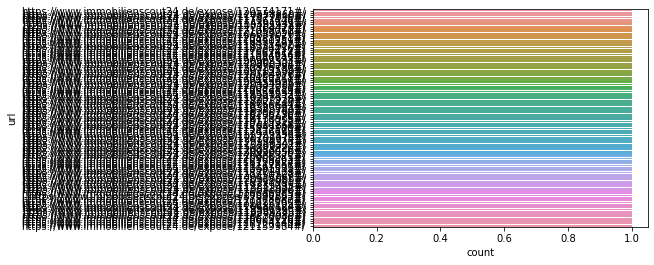

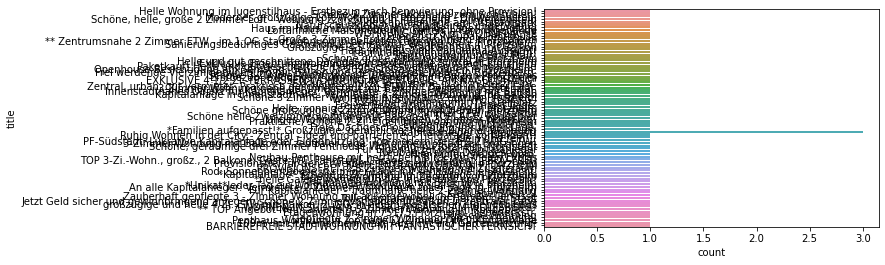

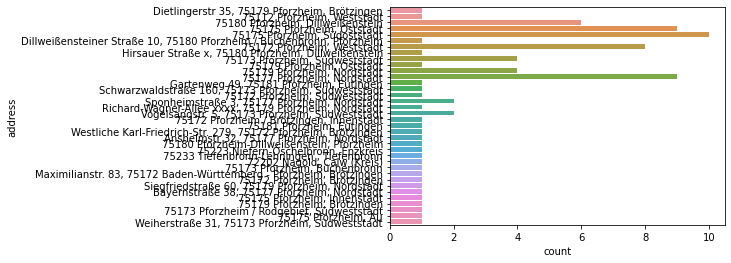

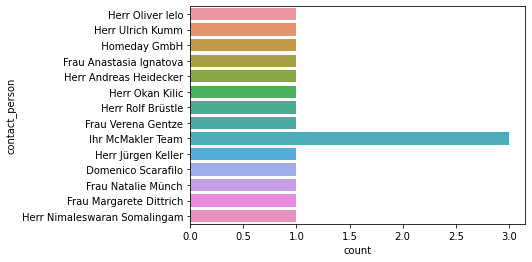

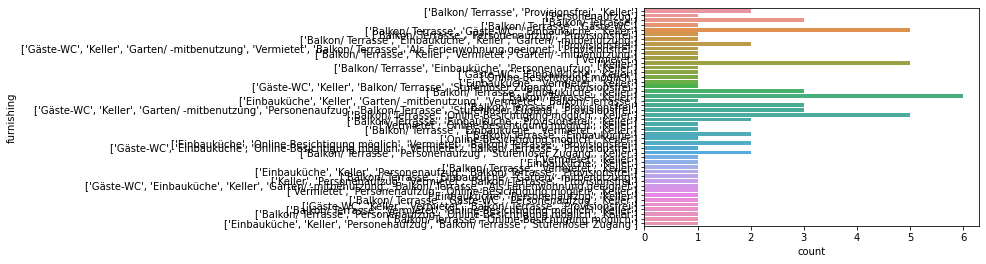

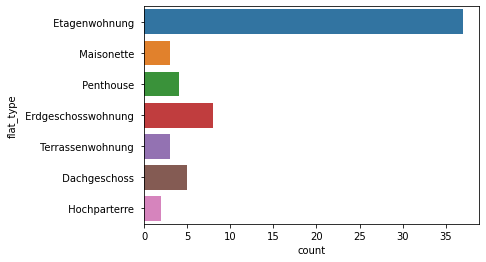

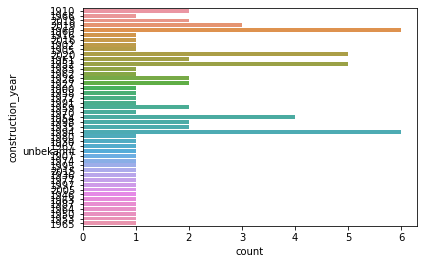

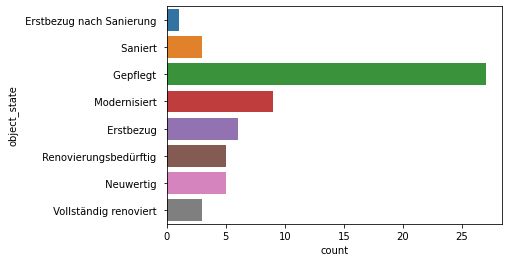

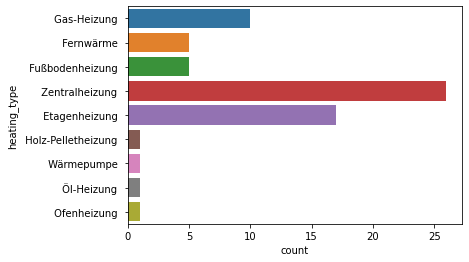

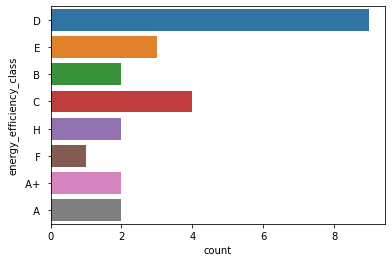

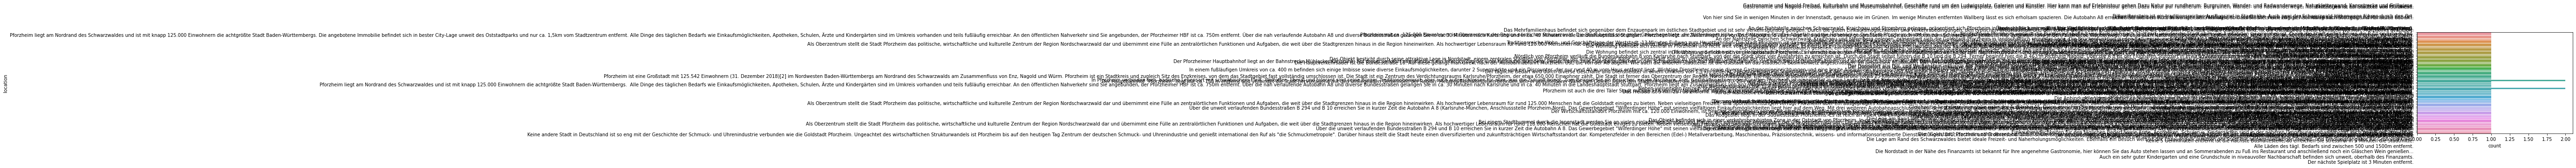

In [46]:
# TODO fix usage of list
# TODO data needs to be fixed
for features in df_base.dtypes[df_base.dtypes == 'object'].index:
    sns.countplot(y=features, data=df_base)
    plt.show()

## Data argmentation
Goal is to calculate the yearly ROI

In [47]:
df_finance = df_base[['url','price_purchase', 'living_area_m2', 'commission_buyer_rate']]
df_finance['price_per_m2'] = df_finance['price_purchase'] / df_finance['living_area_m2']
df_finance['notary_costs'] = notary_percentage * df_finance['price_purchase']

df_finance['land_registry_tax'] = land_registry_tax_percentage * df_finance['price_purchase']
df_finance['real_estate_transfer_tax'] = transfer_tax_percentage * df_finance['price_purchase']
df_finance['commission'] = df_finance['price_purchase'] * df_finance['commission_buyer_rate'] * 0.01 # TODO fix while parsing from scraper already
df_finance['total_buying_price'] = df_finance['price_purchase'] + df_finance['notary_costs'] + df_finance['land_registry_tax'] + df_finance['real_estate_transfer_tax'] + df_finance['commission']
df_finance['equity'] = equity_percentage * df_finance['total_buying_price']
df_finance['debt'] = df_finance['total_buying_price'] - df_finance['equity']
df_finance['interest_rate_monthly'] = interest_rate * df_finance['debt'] / 12
df_finance['mortgage_payment_yearly'] = mortgage_payment_rate * df_finance['debt']
df_finance['mortgage_payment_monthly'] = df_finance['mortgage_payment_yearly'] / 12
df_finance['monthly_rent'] = rent_price_index * df_finance['living_area_m2']
df_finance['additional_costs'] = additional_costs_rate_per_m2 * df_finance['living_area_m2']
df_finance['cashflow'] = df_finance['monthly_rent'] - df_finance['interest_rate_monthly'] - df_finance['mortgage_payment_monthly'] - df_finance['additional_costs']
df_finance['ROI'] = (df_finance['cashflow'] * 12) / df_finance['equity'] 





In [48]:
df_finance.sort_values(by=['ROI'], ascending=False)

url  price_purchase  \
47  https://www.immobilienscout24.de/expose/118116058#/               0   
8   https://www.immobilienscout24.de/expose/121058071#/           53500   
84  https://www.immobilienscout24.de/expose/120489124#/           93000   
60  https://www.immobilienscout24.de/expose/120058446#/          112000   
12  https://www.immobilienscout24.de/expose/120451951#/          220000   
..                                                  ...             ...   
81  https://www.immobilienscout24.de/expose/117868687#/               0   
86  https://www.immobilienscout24.de/expose/118801294#/               0   
88  https://www.immobilienscout24.de/expose/118239089#/               0   
92  https://www.immobilienscout24.de/expose/116123140#/               0   
93  https://www.immobilienscout24.de/expose/121159984#/               0   

    living_area_m2  commission_buyer_rate  price_per_m2  notary_costs  \
47            72.0                   0.00      0.000000           0.0   
8             78.0                   0.00    685.897436         802.5   
84            60.0                   0.00   1550.000000        1395.0   
60            68.0                   0.00   1647.058824        1680.0   
12           125.0                   4.76   1760.000000        3300.0   
..             ...                    ...           ...           ...   
81             0.0                   0.00           NaN           0.0   
86             0.0                   0.00           NaN           0.0   
88             0.0                   0.00           NaN           0.0   
92             0.0                   0.00           NaN           0.0   
93             0.0                   0.00           NaN           0.0   

    land_registry_tax  real_estate_transfer_tax  commission  \
47                0.0                       0.0         0.0   
8               267.5                    2675.0         0.0   
84              465.0                    4650.0         0.0   
60              560.0                    5600.0         0.0   
12             1100.0                   11000.0     10472.0   
..                ...                       ...         ...   
81                0.0                       0.0         0.0   
86                0.0                       0.0         0.0   
88                0.0                       0.0         0.0   
92                0.0                       0.0         0.0   
93                0.0                       0.0         0.0   

    total_buying_price   equity      debt  interest_rate_monthly  \
47                 0.0      0.0       0.0               0.000000   
8              57245.0  11449.0   45796.0              38.163333   
84             99510.0  19902.0   79608.0              66.340000   
60            119840.0  23968.0   95872.0              79.893333   
12            245872.0  49174.4  196697.6             163.914667   
..                 ...      ...       ...                    ...   
81                 0.0      0.0       0.0               0.000000   
86                 0.0      0.0       0.0               0.000000   
88                 0.0      0.0       0.0               0.000000   
92                 0.0      0.0       0.0               0.000000   
93                 0.0      0.0       0.0               0.000000   

    mortgage_payment_yearly  mortgage_payment_monthly  monthly_rent  \
47                    0.000                  0.000000         648.0   
8                   915.920                 76.326667         702.0   
84                 1592.160                132.680000         540.0   
60                 1917.440                159.786667         612.0   
12                 3933.952                327.829333        1125.0   
..                      ...                       ...           ...   
81                    0.000                  0.000000           0.0   
86                    0.000                  0.000000           0.0   
88                    0.000                  0.000000        

In [51]:
df_finance[(df_finance['cashflow'] > 0) ].sort_values(by=['ROI'], ascending=False).head(20)

url  price_purchase  \
47  https://www.immobilienscout24.de/expose/118116058#/               0   
8   https://www.immobilienscout24.de/expose/121058071#/           53500   
84  https://www.immobilienscout24.de/expose/120489124#/           93000   
60  https://www.immobilienscout24.de/expose/120058446#/          112000   
12  https://www.immobilienscout24.de/expose/120451951#/          220000   
17  https://www.immobilienscout24.de/expose/117007427#/          275000   
49  https://www.immobilienscout24.de/expose/117001868#/          209500   
66  https://www.immobilienscout24.de/expose/119712357#/          128000   
5   https://www.immobilienscout24.de/expose/114301441#/          338000   
14  https://www.immobilienscout24.de/expose/119071487#/          279000   
31  https://www.immobilienscout24.de/expose/120454936#/           95000   
30  https://www.immobilienscout24.de/expose/120455019#/           83000   
76  https://www.immobilienscout24.de/expose/118812437#/          289000   
16  https://www.immobilienscout24.de/expose/118228416#/          220000   
34  https://www.immobilienscout24.de/expose/119922529#/          160000   
28  https://www.immobilienscout24.de/expose/120455315#/          127000   
29  https://www.immobilienscout24.de/expose/120455181#/          185000   
4   https://www.immobilienscout24.de/expose/117163446#/          159000   
3   https://www.immobilienscout24.de/expose/117877435#/          398000   
13  https://www.immobilienscout24.de/expose/119990289#/          269000   

    living_area_m2  commission_buyer_rate  price_per_m2  notary_costs  \
47           72.00                   0.00      0.000000           0.0   
8            78.00                   0.00    685.897436         802.5   
84           60.00                   0.00   1550.000000        1395.0   
60           68.00                   0.00   1647.058824        1680.0   
12          125.00                   4.76   1760.000000        3300.0   
17          148.00                   4.64   1858.108108        4125.0   
49          107.00                   4.64   1957.943925        3142.5   
66           65.00                   4.64   1969.230769        1920.0   
5           165.65                   4.64   2040.446725        5070.0   
14          136.55                   4.76   2043.207616        4185.0   
31           45.44                   5.80   2090.669014        1425.0   
30           39.34                   5.80   2109.811896        1245.0   
76          132.00                   4.76   2189.393939        4335.0   
16          100.00                   4.76   2200.000000        3300.0   
34           68.00                   0.00   2352.941176        2400.0   
28           56.70                   5.80   2239.858907        1905.0   
29           81.72                   4.64   2263.827704        2775.0   
4            70.00                   4.64   2271.428571        2385.0   
3           173.00                   4.64   2300.578035        5970.0   
13          116.00                   4.64   2318.965517        4035.0   

    land_registry_tax  real_estate_transfer_tax  commission  \
47                0.0                       0.0         0.0   
8               267.5                    2675.0         0.0   
84              465.0                    4650.0         0.0   
60              560.0                    5600.0         0.0   
12             1100.0                   11000.0     10472.0   
17             1375.0                   13750.0     12760.0   
49             1047.5                   10475.0      9720.8   
66              640.0                    6400.0      5939.2   
5              1690.0                   16900.0     15683.2   
14             1395.0                   13950.0     13280.4   
31              475.0                    4750.0      5510.0   
30              415.0                    4150.0      4814.0   
76             1445.0                   14450.0     13756.4   
16             1100.0                   11000.0     10472.0 

In [50]:
df_finance[(df_finance['cashflow'] > 0) & (df_finance['equity'] <= 25000) ].sort_values(by=['ROI'], ascending=False)

url  price_purchase  \
47  https://www.immobilienscout24.de/expose/118116058#/               0   
8   https://www.immobilienscout24.de/expose/121058071#/           53500   
84  https://www.immobilienscout24.de/expose/120489124#/           93000   
60  https://www.immobilienscout24.de/expose/120058446#/          112000   
31  https://www.immobilienscout24.de/expose/120454936#/           95000   
30  https://www.immobilienscout24.de/expose/120455019#/           83000   
11  https://www.immobilienscout24.de/expose/120523571#/          109000   
20  https://www.immobilienscout24.de/expose/121086745#/           73000   
36  https://www.immobilienscout24.de/expose/119387232#/          106800   

    living_area_m2  commission_buyer_rate  price_per_m2  notary_costs  \
47           72.00                   0.00      0.000000           0.0   
8            78.00                   0.00    685.897436         802.5   
84           60.00                   0.00   1550.000000        1395.0   
60           68.00                   0.00   1647.058824        1680.0   
31           45.44                   5.80   2090.669014        1425.0   
30           39.34                   5.80   2109.811896        1245.0   
11           40.00                   4.76   2725.000000        1635.0   
20           26.00                   3.41   2807.692308        1095.0   
36           38.03                   4.64   2808.309230        1602.0   

    land_registry_tax  real_estate_transfer_tax  commission  \
47                0.0                       0.0        0.00   
8               267.5                    2675.0        0.00   
84              465.0                    4650.0        0.00   
60              560.0                    5600.0        0.00   
31              475.0                    4750.0     5510.00   
30              415.0                    4150.0     4814.00   
11              545.0                    5450.0     5188.40   
20              365.0                    3650.0     2489.30   
36              534.0                    5340.0     4955.52   

    total_buying_price     equity       debt  interest_rate_monthly  \
47                0.00      0.000      0.000               0.000000   
8             57245.00  11449.000  45796.000              38.163333   
84            99510.00  19902.000  79608.000              66.340000   
60           119840.00  23968.000  95872.000              79.893333   
31           107160.00  21432.000  85728.000              71.440000   
30            93624.00  18724.800  74899.200              62.416000   
11           121818.40  24363.680  97454.720              81.212267   
20            80599.30  16119.860  64479.440              53.732867   
36           119231.52  23846.304  95385.216              79.487680   

    mortgage_payment_yearly  mortgage_payment_monthly  monthly_rent  \
47                  0.00000                  0.000000        648.00   
8                 915.92000                 76.326667        702.00   
84               1592.16000                132.680000        540.00   
60               1917.44000                159.786667        612.00   
31               1714.56000                142.880000        408.96   
30               1497.98400                124.832000        354.06   
11               1949.09440                162.424533        360.00   
20               1289.58880                107.465733        234.00   
36               1907.70432                158.975360        342.27   

    additional_costs   cashflow       ROI  
47            64.800  583.20000       inf  
8             70.200  517.31000  0.542206  
84            54.000  286.98000  0.173036  
60            61.200  311.12000  0.155768  
31            40.896  153.74400  0.086083  
30            35.406  131.40600  0.084213  
11            36.000   80.36320  0.039582  
20            23.400   49.40140  0.036776  
36            34.227   69.57996  0.035014